<a href="https://colab.research.google.com/github/flaviagaia/SpaCy/blob/main/3_Classifica%C3%A7%C3%A3o_de_Textos_do_Twitter_com_spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de textos do Twitter com spaCy

# Etapa 1: Importação e instalação das bibliotecas

In [ ]:
#!pip install spacy --upgrade
!pip install -q spacy==2.2.3 #Atualizado: 02/05/2021 Obs: utilizar esta versão.

     |████████████████████████████████| 10.4 MB 3.3 MB/s 
     |████████████████████████████████| 2.2 MB 50.0 MB/s 


In [ ]:
!python3 -m spacy download pt_core_news_sm

     |████████████████████████████████| 21.2 MB 1.1 MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186281 sha256=0676010f9eccdff2d021446cfb3cdc288f96d69529527a3d722f31ce1d2d4b9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mns_6jr1/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [ ]:
import spacy
import pt_core_news_sm

In [ ]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np
import re

# Etapa 2: Carregamento das bases de dados

- Link Kaggle: https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis#TweetsNeutralHash.csv

## Base de treinamento

- Negative label: 0
- Positive label: 1

In [ ]:
base_treinamento = pd.read_csv('/content/Train50.csv', delimiter=';')

In [ ]:
base_treinamento.shape

(13745, 5)

In [ ]:
base_treinamento.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1.0,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1.0,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1.0,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1.0,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1.0,:)


In [ ]:
base_treinamento.tail()

,id,tweet_text,tweet_date,sentiment,query_used
13740,1047509028446883842,"Um tuíte desses, bicho! :))) https://t.co/FUNc...",Wed Oct 03 15:29:48 +0000 2018,1.0,:)
13741,1047509010243641345,@natanaelewu Votaria nulo :) os três são tão r...,Wed Oct 03 15:29:44 +0000 2018,1.0,:)
13742,1047509005923495936,minhas tias sao um clássico pé no saco :),Wed Oct 03 15:29:43 +0000 2018,1.0,:)
13743,1047508980380196864,Faxina virtual hoje :),Wed Oct 03 15:29:37 +0000 2018,1.0,:)
13744,10475089519,NaN,NaN,NaN,NaN


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


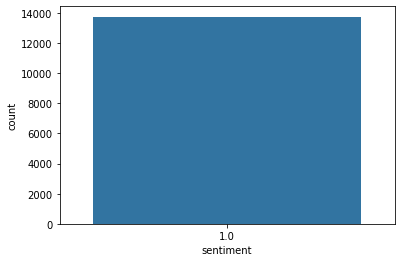

In [ ]:
sns.countplot(base_treinamento['sentiment'], label = 'Contagem');

In [ ]:
base_treinamento.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [ ]:
base_treinamento.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1.0
1,"@behin_d_curtain Para mim, é precisamente o co...",1.0
2,Vou fazer um video hoje... estou pensando em f...,1.0
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1.0
4,Valoriza o coração do menininho que vc tem. El...,1.0


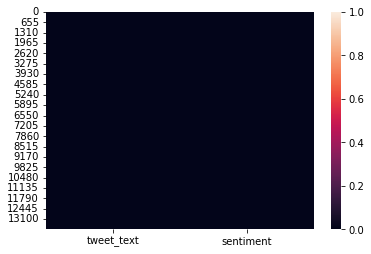

In [ ]:
sns.heatmap(pd.isnull(base_treinamento));

## Base de teste

In [ ]:
base_teste = pd.read_csv('/content/Test.csv', delimiter=';')

In [ ]:
base_teste.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)


In [ ]:
base_teste.shape

(5000, 5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


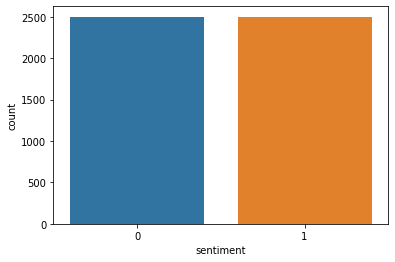

In [ ]:
sns.countplot(base_teste['sentiment'], label='Contagem');

In [ ]:
base_teste.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [ ]:
base_teste.head()

,tweet_text,sentiment
0,@Gazo1a Nossa! Muito obrigada :),1
1,@BerzGamer vai pa puta que te pariu :),1
2,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,1
3,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",1
4,Estávamos em casa do Zé e eu estava a morrer d...,1


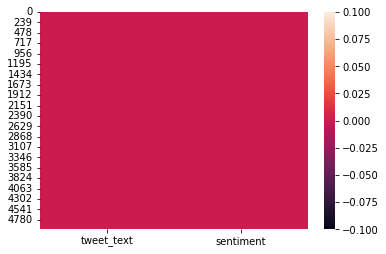

In [ ]:
sns.heatmap(pd.isnull(base_teste));

# Etapa 3: Função para pré-processamento dos textos

- Letras minúsculas
- Nome do usuário (@)
- URLs
- Espaços em branco
- Emoticons
- Stop words
- Lematização
- Pontuações

In [ ]:
pln = pt_core_news_sm.load()
pln

In [ ]:
base_treinamento['tweet_text'][1]

'@behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)'

In [ ]:
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

In [ ]:
print(stop_words)

{'mil', 'três', 'dez', 'mês', 'na', 'desde', 'porquanto', 'maior', 'nessa', 'vós', 'certeza', 'fará', 'em', 'deve', 'aquela', 'no', 'posição', 'ser', 'temos', 'minhas', 'à', 'tiveste', 'números', 'pouca', 'ontem', 'quer', 'já', 'isso', 'deverá', 'ou', 'cima', 'como', 'esse', 'exemplo', 'do', 'grandes', 'sob', 'menos', 'tem', 'diante', 'sete', 'era', 'pelas', 'fazemos', 'tive', 'ambos', 'todo', 'apontar', 'quê', 'é', 'seis', 'quinta', 'onze', 'ir', 'fazer', 'estará', 'ambas', 'cento', 'ela', 'maiorias', 'tentaram', 'nosso', 'depois', 'favor', 'terceiro', 'povo', 'último', 'isto', 'lugar', 'entre', 'questão', 'esta', 'se', 'vos', 'obrigado', 'inclusive', 'dezasseis', 'querem', 'catorze', 'usar', 'portanto', 'qual', 'ver', 'dizem', 'põem', 'assim', 'tu', 'deste', 'dois', 'logo', 'quarto', 'conselho', 'podem', 'primeira', 'podia', 'apoio', 'outros', 'lado', 'naquela', 'novo', 'breve', 'quarta', 'num', 'tendes', 'para', 'toda', 'próxima', 'neste', 'aquilo', 'devem', 'inicio', 'pois', 'aquel

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def preprocessamento(texto):
  # Letras minúsculas
  texto = texto.lower()

  # Nome do usuário
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)

  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

  # Espaços em branco
  texto = re.sub(r" +", ' ', texto)

  # Emoticons
  lista_emocoes = {':)': 'emocaopositiva',
                   ':d': 'emocaopositiva',
                   ':(': 'emocaonegativa'}
  for emocao in lista_emocoes:
    texto = texto.replace(emocao, lista_emocoes[emocao])

  # Lematização
  documento = pln(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)
  
  # Stop words e pontuações
  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return lista

In [ ]:
texto_teste = '@behin_d_curtain :D Para :( mim, http://www.iaexpert.com.br é precisamente o contrário :) Vem a chuva e vem a boa disposição :)'
resultado = preprocessamento(texto_teste)
resultado

'  emocaopositiva parir emocaonegativa mim precisamente o contrário emocaopositiva vir o chuva e vir o disposição emocaopositiva'

# Etapa 4: Pré-processamento da base de dados

### Limpeza dos textos

In [ ]:
base_treinamento.head(10)

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1.0
1,"@behin_d_curtain Para mim, é precisamente o co...",1.0
2,Vou fazer um video hoje... estou pensando em f...,1.0
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1.0
4,Valoriza o coração do menininho que vc tem. El...,1.0
5,@KingJokerLeto mas amiga eu to aqui ainda :),1.0
6,"@RivasJairo Bravo, Jairo!!! :)))",1.0
7,@inquilinasls @Spotify socorro ksoaksosks acho...,1.0
8,"@chimekarlla gosto muito de fazenda :) , mas m...",1.0
9,Amanha vou ver venom :D,1.0


In [ ]:
base_treinamento['tweet_text'] = base_treinamento['tweet_text'].apply(preprocessamento)

AttributeError: ignored

In [ ]:
base_treinamento.head(10)

In [ ]:
base_teste['tweet_text'] = base_teste['tweet_text'].apply(preprocessamento)

In [ ]:
base_teste.head(10)

### Tratamento da classe

In [ ]:
exemplo_base_dados = [["este trabalho é agradável", {"POSITIVO": True, "NEGATIVO": False}],
                      ["este lugar continua assustador", {"POSITIVO": False, "NEGATIVO": True}]]

In [ ]:
base_dados_treinamento_final = []
for texto, emocao in zip(base_treinamento['tweet_text'], base_treinamento['sentiment']):
  if emocao == 1:
    dic = ({'POSITIVO': True, 'NEGATIVO': False})
  elif emocao == 0:
    dic = ({'POSITIVO': False, 'NEGATIVO': True})

  base_dados_treinamento_final.append([texto, dic.copy()])

In [ ]:
len(base_dados_treinamento_final)

In [ ]:
base_dados_treinamento_final[10:15]

In [ ]:
base_dados_treinamento_final[45000:45005]

# Etapa 5: Criação do classificador

In [ ]:
modelo = spacy.blank('pt')
categorias = modelo.create_pipe("textcat")
categorias.add_label("POSITIVO")
categorias.add_label("NEGATIVO")
modelo.add_pipe(categorias)
historico = []

In [ ]:
modelo.begin_training()
for epoca in range(20):
  random.shuffle(base_dados_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512):
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    modelo.update(textos, annotations, losses=losses)
    historico.append(losses)
  if epoca % 5 == 0:
    print(losses)

In [ ]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [ ]:
historico_loss = np.array(historico_loss)
historico_loss

In [ ]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

In [ ]:
modelo.to_disk("modelo")

# Etapa 6: Testes com uma frase

In [ ]:
modelo_carregado = spacy.load('modelo')
modelo_carregado

## Texto positivo

In [ ]:
texto_positivo = base_teste['tweet_text'][21]
texto_positivo

In [ ]:
previsao = modelo_carregado(texto_positivo)
previsao

In [ ]:
previsao.cats

In [ ]:
texto_positivo = 'eu gosto muito de você'
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

In [ ]:
modelo_carregado(texto_positivo).cats

## Texto negativo

In [ ]:
base_teste['tweet_text'][4000]

In [ ]:
texto_negativo = base_teste['tweet_text'][4000]
previsao = modelo_carregado(texto_negativo)
previsao.cats

# Etapa 7: Avaliação do modelo

## Avaliação na base de treinamento


In [ ]:
previsoes = []
for texto in base_treinamento['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [ ]:
previsoes

In [ ]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [ ]:
previsoes_final

In [ ]:
respostas_reais = base_treinamento['sentiment'].values
respostas_reais

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(respostas_reais, previsoes_final)

In [ ]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

In [ ]:
sns.heatmap(cm, annot=True)

## Avaliação na base de teste

In [ ]:
previsoes = []
for texto in base_teste['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [ ]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [ ]:
respostas_reais = base_teste['sentiment'].values

In [ ]:
accuracy_score(respostas_reais, previsoes_final)

In [ ]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

In [ ]:
sns.heatmap(cm, annot=True)